# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%bash
pip install faiss-cpu
pip install -U git+https://github.com/dsevero/craystack@dsevero/uniform-rans-and-scalar-types
pip install sortedcontainers tqdm

# Problem Setup

FAISS is a database designed to store vectors of large dimensionality, usually representing pre-trained embeddings, for similarity search.
Given a query vector, FAISS returns a set of the k-nearest neighbors available in the database under some pre-defined distance metric (usually the L2 distance).
Returning the exact set requires an exhaustive search over the entire database for each query vector which quickly becomes intractable in practice.
FAISS can instead return an approximate solution by performing a two-stage search on a coarse and fine grained set of database vectors.
The database undergoes a training phase where vectors are clustered into sets and assigned a representative (i.e., a centroid).
FAISS first selects the k'-nearest clusters, `k' < k`, based on the distance of the query to the centroids, and then performs an exhaustive search within them to return the approximate k-nearest neighbors.

The mapping between cluster and the embeddings contained in it is done through an inverted file (IVF), a map from `cluster_id: int` to an array of `embedding_ids: NDArray[uint]`.
Search is performed exhaustively inside the clusters, all embeddings with id in `embedding_ids: NDArray[uint]` will have their distance with respect to the query computed, which is then used to rank the embeddings to return the k-nearest neighbours.
This means the resulting list of k-nearest neighbour ids is invariant to permutations of the `embedding_ids: NDArray[uint]` array.
From an information theoretic point of view, this array is actually a set of elements.

The objective of this work is to reduce the memory footprint of `embedding_ids: NDArray[uint]` by applying Random Order Coding (ROC) [1].

ROC can be viewed as a lossless encoding method with the following signature

```python
def ROC_encode(arr: NDArray[uint]) -> tuple[NDArray[uint], int]:
    ...
```
where if `arr_comp, size = ROC_encode(arr)`, the output array `arr_comp` has memory footprint such that `arr_comp.nbytes == arr.nbytes - math.log2(math.factorial(len(arr)))/8` bytes (roughly).
The second term `math.log2(...)` is the savings incurred by ROC.
Note: I'm abusing notation here by using `==`, since that expression will likely evaluate to `False` as there are small overheads in the algorithm, but it is very very close in practice; usually up to the 3rd decimal place in terms of % for a few hundred elements.

The variable `size = len(arr)` is required to specify the inverse (decode),

```python
def ROC_decode(arr_comp: NDArray[uint], size: int) -> NDArray[uint]:
    ...
```

`ROC_encode` and `ROC_decode` form an inverse pair, in the sense that the following test always passes,

```python
assert numpy.all(arr == ROC_decode(*ROC_encode(arr)))
```

The savings in memory footprint can be easily calculated as it depends only on the size `len(arr)`.
Here's a plot of the savings, per element, as a function of `n = len(arr)`, in bytes.

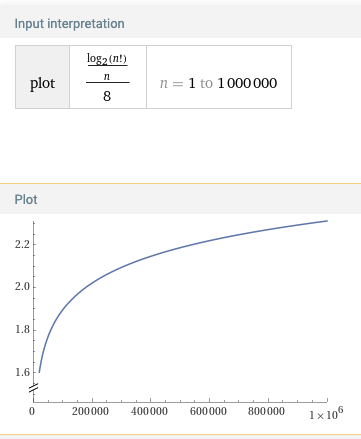

The percentage savings will depend on the size of each index (a typical index that is considered large will be 64 bits = 8 bytes).
The table below shows the percentage savings assuming 32 and 64 bit ids.

| `n` | 32 bit | 64 bit |
|-----|--------|--------|
| 1e3 | 27%    | 13%    |
| 1e4 | 37%    | 18%    |
| 1e5 | 47%    | 24%    |
| 1e6 | 57%    | 29%    |
| 1e7 | 68%    | 34%    |

In general, since `log(n!)/n = O(log n)`, we can expect that an order of magnitude increase in the cluster size `n` will result in a linear increase in the savings percentage (which can be seen in the table).

To achieve this, I wrote a small library called `rpc` (which stands for _Random Permutation Codes_, a generalized version of ROC which I developed in my thesis).
`rpc` uses the asymmetric numeral systems (ANS) implementation available in the [craystack library](https://github.com/j-towns/craystack).

In what follows I'll show how to use `rpc` together with `faiss`, and then I'll explain how it works under the hood.

[1] [Severo, Daniel, James Townsend, Ashish Khisti, Alireza Makhzani, and Karen Ullrich. "Compressing multisets with large alphabets." IEEE Journal on Selected Areas in Information Theory 3, no. 4 (2022): 605-615.](https://arxiv.org/abs/2107.09202)

# How to use `rpc`

Here I'll show a small example of how to use the `rpc` library to compress a single `embedding_ids: NDArray[uint]`.

## Prepare the FAISS database (1M database vectors, 1k clusters)

In [3]:
import faiss
from faiss.contrib.datasets import SyntheticDataset
from faiss.contrib.inspect_tools import get_invlist

# Make a synthetic dataset with 1M database vectors (`nb`) and 1M training examples (`nt`).
# The number of queries `nq` and dimension `d` don't affect the compression rate of the indices.
ds = SyntheticDataset(d=2, nt=int(1e6), nb=int(1e6), nq=1)

# Create, train, and populate the C++ index: `\sqrt(10B) = 100k` clusters, compress vectors to 8-bit integers with scalar quantization.
index = faiss.index_factory(ds.d, "IVF1000,SQ8")
index.train(ds.get_train())
index.add(ds.get_database())

# Compress a single cluster

In [4]:
from rpc.codecs import ClusterCodec, UniformScalarCodec
from rpc.rans import initialize_ans_state, compute_ans_state_size_in_bytes

# Get the embeddings located at cluster 23.
cluster_id = 23
embedding_ids, _ = get_invlist(index.invlists, cluster_id)

# Initialize an ANS state and ClusterCodec.
# Finally, encode the embedding ids as a set. 
# A UserWarning will be raised regarding "Popping from empty message". This is expected. 
# First, the ClusterCodec needs to sample (using an ANS decode) a uniform integer 
# in the range [0, cluster_size) to initiate the algorithm. However, the ANS stack is empty at the start
# and therefore random data must be generated and encoded into the state to enable sampling (this is taken care of by rpc.rans).
ans_state = initialize_ans_state()
codec = ClusterCodec(cluster_size=len(embedding_ids))
ans_state = codec.encode(embedding_ids, ans_state)

# We should also encode the cluster size to make it a fair comparison, given that it is needed during decoding.
ans_state = UniformScalarCodec(prec=index.ntotal).encode(len(embedding_ids), ans_state)

# We can compute the savings (should be just above 13% for this example).
# The savings increase as the size of the cluster increases, and will be roughly `\log_2(cluster_size!)`.
# This matches the first row in the savings table we discussed before.
1 - compute_ans_state_size_in_bytes(ans_state)/embedding_ids.nbytes

/private/home/dsevero/repos/NeuralCompressionInternal/projects/intern_faiss_ivf_compression/craystack/rans.py:39: UserWarning: Popping from empty message. Generating random data.
  warn("Popping from empty message. Generating random data.")


0.1338546458141674

For the sake of closure, we can define the ROC function mentioned before as follows.

In [5]:
from rpc.codecs import ClusterCodec, BigUniformScalarCodec
from rpc.rans import initialize_ans_state
from rpc.types import uint
from craystack.rans import flatten, unflatten
from numpy.typing import NDArray
import numpy as np

def ROC_encode(arr: NDArray[uint]) -> tuple[NDArray[uint], int]:
    codec = ClusterCodec(cluster_size=len(arr))
    ans_state = codec.encode(arr, initialize_ans_state(shape=1))
    return flatten(ans_state), len(arr)

def ROC_decode(arr_comp: NDArray[uint], size: int) -> NDArray[uint]:
    codec = ClusterCodec(cluster_size=size)
    ans_state, arr = codec.decode(unflatten(arr_comp, shape=1))
    return arr

arr = np.arange(10, dtype=np.uint32)
arr_comp, size = ROC_encode(arr)
assert np.all(ROC_decode(arr_comp, size) == arr)
arr, arr_comp, size

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint32),
 array([       591, 3364356096,          0,          6,          0,
        2147483653,          0,          4,          0,          2,
                 0, 3435921417,     458752, 2863311530,      65536,
                 0,          0,  536870912,     196608, 1431655765,
            524288, 2735729615], dtype=uint32),
 10)

# Under the hood.

So what exactly is `ClusterCodec` doing?
To understand in detail, we first need to look at `containers.SortedList`.

A `SortedList` is similar to a regular python `list`, but elements are always guaranteed to be sorted.
This is implemented internally in `containers` via the `bisect` standard library.

Given a sorted list, there are 2 methods which matter to us: `add(value: Any)`, which adds an element (in-place) such that the resulting list is still sorted;
and `pop(index: int = -1)`, which returns and removes the element at position `index` (remember that the list is sorted, so `index` is also the rank of the element in that list).

Second, the basic type of `rpc` is `rpc.codecs.Codec`, which is shown below.

```python
class Codec[SymbolType](ABC):
    @abstractmethod
    def encode(self, symbols: SymbolType, ans_state: ANSState) -> ANSState:
        pass

    @abstractmethod
    def decode(self, ans_state: ANSState) -> tuple[ANSState, SymbolType]:
        pass
```

This is an abstract class (think of it as a "template for a class") that dictates the signature of the `encode` and `decode` methods.
The "`[SymbolType]`" syntax specifies what types the codec can compress (this is known as a "generic type").
This will usually be `NDArray[uint]`, `uint`, or `SortedList`.
All codecs in `rpc` inherit this class.

Finally, there are in general 2 flavours of codecs in `rpc`: vectorized and scalar codecs.
A vectorized codec will generally have `SymbolType = NDArray[uint]`, while scalar codecs will have `SymbolType = uint`.
By default, codecs are vectorized if there is no mention of "Scalar" in their name (e.g., `rpc.codecs.UniformCodec` is vectorized and `rpc.Codecs.UniformScalarCodec` is not).

Now back to `ClusterCodec`.
It uses another codec in the `rpc` library called `ROCSortedListCodec`.
The code is shown below.

```python
@dataclass
class ROCSortedListCodec(Codec[SortedList[T]]):
    set_size: int
    symbol_codec: Codec[T]
    key: Optional[Callable[[T], Any]] = None
    copy_input: bool = True

    def encode(self, sorted_seq: SortedList[T], ans_state: ANSState) -> ANSState:
        # This can be removed when going to production.
        if self.copy_input:
            sorted_seq = deepcopy(sorted_seq)

        for i in range(self.set_size):
            # Sample/Decode, without replacement, an index using ANS.
            # Initialize a uniform codec for the indices.
            prec = np.uint32(self.set_size - i)
            ans_state, index = UniformScalarCodec(prec).decode(ans_state)

            # `index` is NDArray[uint], need to cast to int to pick the element.
            symbol: T = sorted_seq.pop(int(index))

            # Encode the element into the ans state.
            ans_state = self.symbol_codec.encode(symbol, ans_state)

        return ans_state

    def decode(self, ans_state: ANSState) -> tuple[ANSState, SortedList[T]]:
        # Initialize an empty SortedList of elements of type T.
        sorted_seq: SortedList[T] = SortedList([], key=self.key)

        for i in range(self.set_size):
            # Decode an element from the stack.
            ans_state, symbol = self.symbol_codec.decode(ans_state)

            # Add it to the sorted list and recover `index`.
            sorted_seq.add(symbol)
            index = np.uint32(sorted_seq.index(symbol))

            # Encode `index` back into the state to reverse sampling.
            prec = np.uint32(i + 1)
            ans_state = UniformScalarCodec(prec).encode(index, ans_state)

        return ans_state, sorted_seq
```

The key idea is that, since the result of k-nn is invariant to shuffles of the elements in `embedding_ids: NDArray[uint]`, then we can use the ANS state as a random seed to pick the order for us.
This will be done by decoding an index from the ANS state, which will reduce the size of the ANS state.
It will become clear that, during decoding, we can deduce what the value of the index was selected during encoding, implying we _don't_ have to encode it into the state.

The `embedding_ids: NDArray[uint]` is first converted into `sorted_seq: SortedList[uint]` by `ClusterCodec` (not shown), which is then passed to `ROCSortedListCodec.encode` shown above.

The first step in encoding is to _sample_ a random `index: uint` in the range `[0, self.set_size)`.
This is done with a `UniformScalarCodec`, which is nothing more than a class that encapsulates an ANS decode operation available in the craystack library.
The value of `index: uint` will dictate which element in `sorted_seq: SortedList[uint]` will be encoded at that step.
This is chosen via the `pop` method, resulting in `symbol: uint` (note: `symbol: uint` is _exactly_ the element `embedding_ids[index]: uint`).

After chosing which symbol to encode, `symbol: uint` is encoded into the ans state using the `self.symbol_codec` (which is specified by the user).
A common use case is to have 64 bit unsigned integers for the ids, so we can just use `symbol_codec = UniformScalarCodec(prec=1 << 64)`, a uniform codec over `2^64` values.

This procedure of sampling an index, popping an element from the sorted list, and encoding the chosen element repeats until `sorted_seq` is empty, implying all elements are encoded.

To decode, we initialize an empty `SortedList`, and perform the exact opposite set of operations as in encoding.
It is easiest to understand decoding if we always remember that we are undoing the operations done to the ANS state by encoding.
Therefore, the first step in decoding is to undo the last encoding step.

After encoding, since ANS is a stack-like codec (the last element encoded is the first to be decoded), the top of the ANS stack will contain _the last_ embedding id encoded with `self.symbol_codec`.
Therefore, In the for loop, we first decode using `self.symbol_codec` to recover that element.
We now input the decoded element into the sorted sequence.
**Since the sorted sequence is guaranteed to be sorted, we know that the value of `index` sampled from the ANS state at the corresponding encoding step has to be the index of the element AFTER adding it to the sorted list.**
We therefore recover the index with the `SortedList.index` method.
Finally, we encode the value of `index` into the ANS state to restore the state to the same value BEFORE the start of the corresponding encoding step.

The bit savings come from the decoding of the index.
It is easy to show this corresponds to the "information" contained in a permutation.
If `n` is `self.set_size == len(embedding_ids) == len(sorted_seq)`, then the first encoding step (i.e., `i=0` in the for loop) uses a uniform codec over `n` elements (see the value of `prec` in the `encode` method).
For general `i`, the codec is uniform with precision `prec - i`
The reduction in the ans state from using a uniform codec is approximately `math.log2(prec - i)` at each step, implying the total savings is roughly `math.log2(math.factorial(prec))` bits.